# OpenVINO Benchmark Analysis

## Import libraries and data

In [1]:
import os
import tqdm
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
summary_path = "~/applications.automotive.benchmarks/output/selected_face_models_i7-1370PRE_CPU_iGPU/08_06_2023-16_43_34_summary.csv"
accuracy =  {'facial-landmarks-35-adas-0002': 0.894,
             'face-reidentification-retail-0095': 0.9947,
             'facial-landmarks-98-detection-0001': 0.8677,
             'face-detection-0200': 0.8674,
             'face-detection-retail-0004': 0.83,
             'face-detection-retail-0005': 0.8452,
             'face-detection-0202': 0.9194,
             'face-detection-0204': 0.9289,
             'face-detection-adas-0001': 0.941,
             'face-detection-0205': 0.9357,
             'face-detection-0206': 0.9427}
data = pd.read_csv(summary_path).sort_values("Throughput (fps)", ascending=False)
data["Accuracy"] = data["Model"].map(accuracy)
multidata = data.set_index(["Model", "Hint", "Quantization", "Device"], inplace=False).unstack([-1,-2,-3])

In [3]:
data.groupby(["Model", "Hint", "Quantization", "Device"]).last().style.set_sticky(axis=1)

In [4]:
display(multidata.style.set_sticky(axis=0))

## Organizing data

In [5]:
fp16 = data[data["Quantization"] == "FP16"].drop("Quantization", axis=1)
fp32 = data[data["Quantization"] == "FP32"].drop("Quantization", axis=1)
latency = data[data["Hint"] == "latency"].drop("Hint", axis=1)
throughput = data[data["Hint"] == "throughput"].drop("Hint", axis=1)
cpu = data[data["Device"] == "CPU"].drop("Device", axis=1)
gpu = data[data["Device"] == "GPU"].drop("Device", axis=1)

In [6]:
# Dictionary for storing individual setting comparison subframes (ex. FP16 vs FP32, CPU vs GPU, etc)
comp = {}
settings = {"Hint": ["latency", "throughput"],
            "Quantization":["FP32", "FP16"], 
            "Device": ["CPU", "GPU"]}

for setting in settings:
    subframes = []
    first_columns = ["Model"] + list(settings.keys())
    first_columns.remove(setting)
    options = settings[setting]
    for option in options:
        subframes.append(data[data[setting] == option].drop(setting, axis=1))
    curr_df = subframes[0]
    for df in subframes[1:]:
        curr_df = curr_df.merge(df, on=first_columns, suffixes=[" "+s for s in options]).sort_index(axis=1)
    if len(settings[setting]) == 2:
        first_columns.extend(["Delta (fps)", "Delta %"])
        curr_df[first_columns[-2]] = curr_df[f"Throughput (fps) {options[1]}"] - curr_df[f"Throughput (fps) {options[0]}"]
        curr_df[first_columns[-1]] = round(curr_df["Delta (fps)"] * 100 / curr_df[f"Throughput (fps) {options[0]}"], 2)
    comp[setting] = curr_df[first_columns + [column for column in curr_df if column not in first_columns]]

ch = comp["Hint"]
cq = comp["Quantization"]
cd = comp["Device"]

In [7]:
cd

,Model,Hint,Quantization,Delta (fps),Delta %,Accuracy CPU,Accuracy GPU,Duration (ms) CPU,Duration (ms) GPU,First Inference Time (ms) CPU,...,Latency Median (ms) CPU,Latency Median (ms) GPU,Latency Min (ms) CPU,Latency Min (ms) GPU,Model Compile Time (ms) CPU,Model Compile Time (ms) GPU,Model Read Time (ms) CPU,Model Read Time (ms) GPU,Throughput (fps) CPU,Throughput (fps) GPU
0,facial-landmarks-35-adas-0002,throughput,FP16,4617.93,101.62,0.8940,0.8940,60006.61,60128.57,1.75,...,3.25,110.71,1.61,45.31,143.94,2613.19,29.59,12.08,4544.30,9162.23
1,facial-landmarks-35-adas-0002,throughput,FP32,4792.68,109.69,0.8940,0.8940,60005.03,60130.69,1.69,...,3.28,110.73,1.81,30.91,143.56,2667.11,24.46,10.17,4369.23,9161.91
2,facial-landmarks-35-adas-0002,latency,FP32,-146.26,-19.05,0.8940,0.8940,60001.65,60002.08,1.71,...,1.20,1.47,0.85,1.23,70.01,1310.69,25.54,11.13,767.76,621.50
3,facial-landmarks-35-adas-0002,latency,FP16,-155.44,-20.40,0.8940,0.8940,60002.19,60001.84,1.70,...,1.20,1.50,0.88,1.25,99.81,1226.66,22.17,13.81,762.04,606.60
4,face-reidentification-retail-0095,throughput,FP16,975.76,133.85,0.9947,0.9947,60010.81,60068.29,5.69,...,7.28,37.27,3.91,11.75,101.35,3114.65,32.65,13.59,728.97,1704.73
5,face-reidentification-retail-0095,throughput,FP32,978.96,135.15,0.9947,0.9947,60019.77,60042.60,5.50,...,7.33,37.28,4.01,20.32,104.61,3183.86,25.37,10.91,724.36,1703.32
6,facial-landmarks-98-detection-0001,throughput,FP16,712.10,109.71,0.8677,0.8677,60026.34,60372.41,7.87,...,25.20,187.92,9.59,90.80,613.02,6303.01,55.34,56.38,649.05,1361.15
7,facial-landmarks-98-detection-0001,throughput,FP32,718.43,113.58,0.8677,0.8677,60027.15,60260.43,7.80,...,25.43,188.03,13.32,91.48,588.57,6499.00,59.26,48.66,632.51,1350.94
8,face-detection-0200,throughput,FP16,271.28,53.56,0.8674,0.8674,60017.15,60010.14,4.65,...,10.54,5.00,6.13,2.69,92.27,1181.73,29.84,11.06,506.46,777.74
9,face-detection-0200,throughput,FP32,281.40,56.96,0.8674,0.8674,60013.60,60006.21,5.02,...,10.75,5.03,6.41,3.21,87.81,1146.68,14.59,9.42,493.99,775.39


## Exploratory data analysis

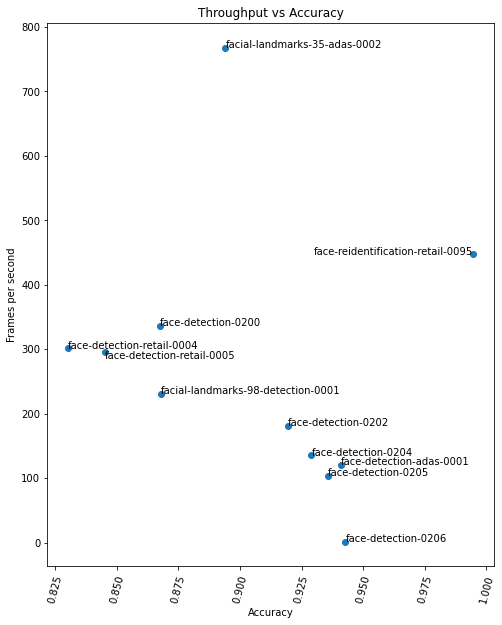

In [12]:
plot_config = ["CPU", "FP32", "latency"]
x = multidata.loc[:, tuple(["Accuracy"] + plot_config)]
y = multidata.loc[:, tuple(["Throughput (fps)"] + plot_config)]
labels = x.index.tolist()

# print("Model                                    Product")
# products = {}
# for i in range(len(labels)):
#     products[labels[i]] = x[i] * y[i]
# for k, v in sorted(products.items(), key=lambda item: item[1], reverse=True):
#     print('{0: <40}'.format(k), v)

plt.scatter(x, y)
for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]), xytext=(x[i] if x[i] != 0.9947 else x[i]-0.065, y[i] if y[i] != 295.99 else y[i]-10))
plt.title("Throughput vs Accuracy")
plt.xlabel("Accuracy")
plt.xticks(rotation=75)
plt.ylabel("Frames per second")
plt.show()
plt.rcParams["figure.figsize"] = (8,10)

In [13]:
 def plot_parameter(parameter, configuration):
    fig, ax = plt.subplots()
    configs = list(settings.keys())
    graph_data = data[(data[configs[0]]==configuration[configs[0]])
                      & (data[configs[1]]==configuration[configs[1]])
                      & (data[configs[2]]==configuration[configs[2]])].sort_values(parameter)
    indexes = graph_data['Model']
    values = graph_data[f'{parameter}']
    bars = ax.barh(indexes, values)
    plt.rcParams["figure.figsize"] = (10,5)
    plt.title(f"{parameter} {configuration}")
    plt.gca().invert_yaxis()
    if parameter[-5:] == ("fps"):
        plt.xlim(0, max(800, values.max() * 1.1))
    plt.xlim(0, max(100, values.max() * 1.1))
    plt.ylabel("Model")
    plt.grid(axis='x')
    ax.bar_label(bars);
    
def compare_parameter(parameter, setting, value):
    other_settings = list(settings.keys())
    other_settings.remove(setting)
    for option1 in settings[other_settings[0]]:
        for option2 in settings[other_settings[1]]:
            plot_parameter(parameter, {setting: value, other_settings[0]: option1, other_settings[1]: option2})
    
def compare_fps(setting, value):
    compare_parameter("Throughput (fps)", setting, value)
    
def create_compare(setting):
    def x(value):
        return compare_fps(setting, value)
    return x

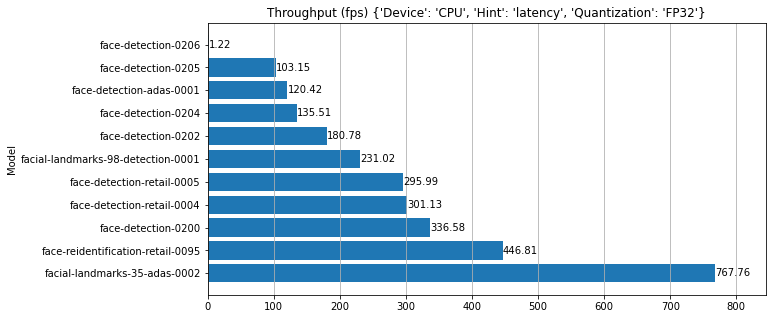

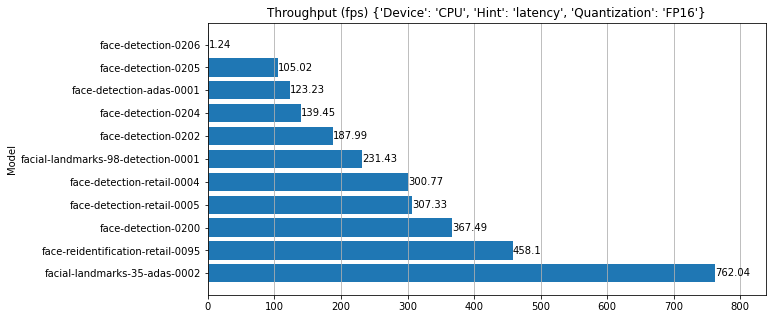

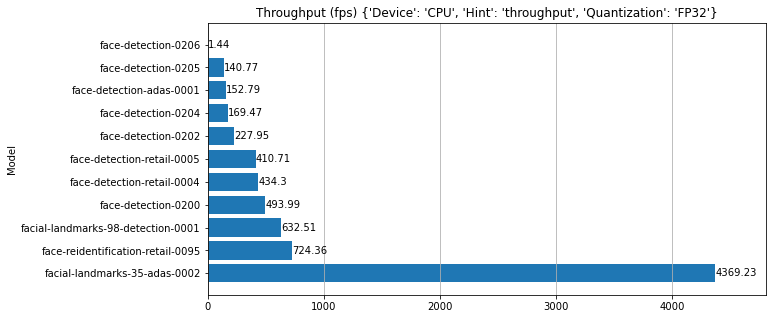

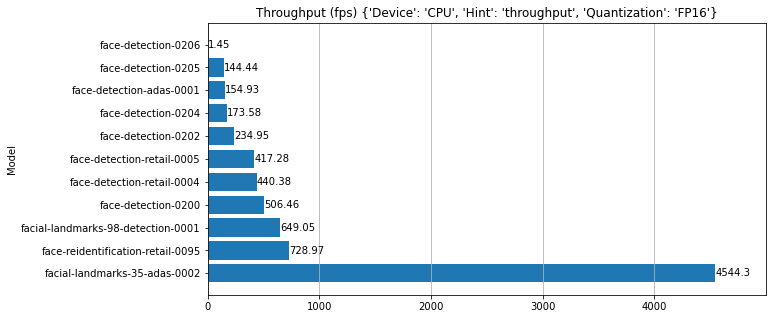

In [15]:
compare_fps("Device", "CPU")

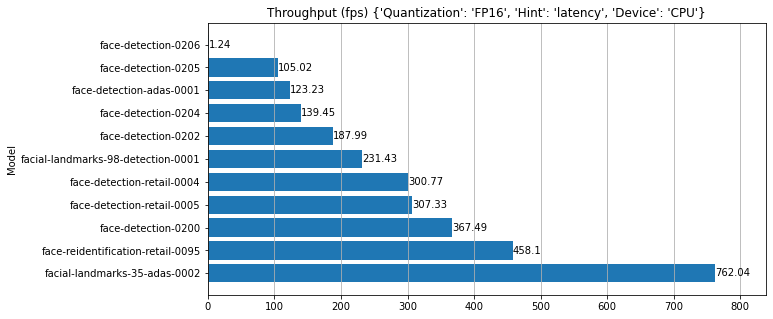

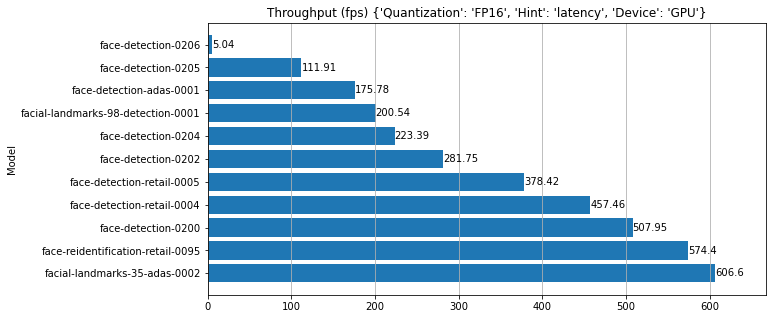

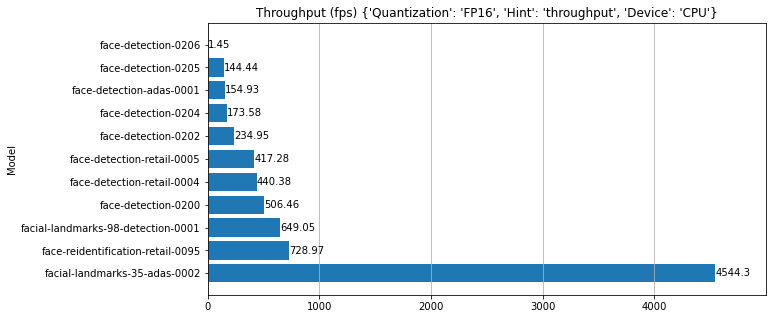

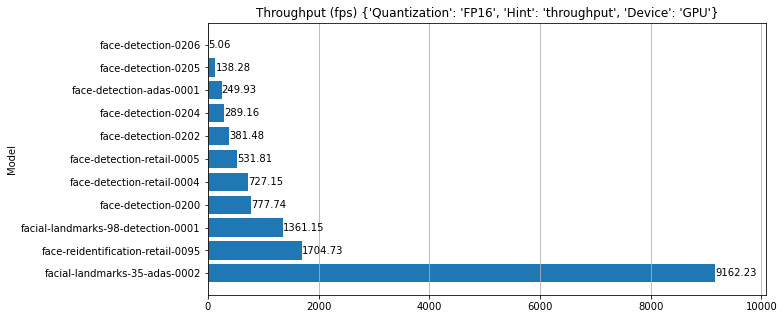

In [16]:
c = create_compare("Quantization")
c("FP16")